# Import bibliotek

In [636]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Callable

from datetime import timedelta

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Constants

In [637]:
DATA_DIR = 'data'
MODELS_DIR = 'models'
MAX_MONTH_DAYS = 31
NUM_MONTHS = 12

# Funkcje pomocnicze

W celu zapisywania i ładowania wytrenowanych modeli wykorzystamy bibliotekę `joblib`

In [638]:
import joblib

def save_model_pipeline(model, filename):
    """Saves a model or pipeline to a file.

    Args:
        model (_type_): model or pipeline to be saved
        filename (_type_): path to which the model will be saved
    """
    joblib.dump(model, filename)


In [639]:
def load_model_pipeline(filename):
    """Loads a model or pipeline from a file.

    Args:
        filename (str): path to model

    Returns:
        _type_: loaded model
    """
    return joblib.load(filename)

W celu przedstawienia predykcji modelu zdefiniujemy poniszą funkcję

In [640]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(15, 7))
    plt.plot(y_true, label='y_true')
    plt.plot(y_pred, label='y_pred')
    plt.title(f'Actual data vs model predictions for {model_name}')
    plt.legend()
    plt.show


# Wczytywanie danych

In [641]:
data_files = os.listdir(DATA_DIR)
data_files

['users.jsonl', 'deliveries.jsonl', 'sessions.jsonl', 'products.jsonl']

In [642]:
df_users = pd.read_json(os.path.join(DATA_DIR, data_files[0]), lines=True)
df_deliveries = pd.read_json(os.path.join(DATA_DIR, data_files[1]), lines=True)
df_sessions = pd.read_json(os.path.join(DATA_DIR, data_files[2]), lines=True)
df_products = pd.read_json(os.path.join(DATA_DIR, data_files[3]), lines=True)

# Wybór danych

In [643]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2020-01-25 19:25:15,102,1538,VIEW_PRODUCT,5.0,NaN
1,124,2020-01-25 19:26:12,102,1542,VIEW_PRODUCT,5.0,NaN
2,124,2020-01-25 19:30:49,102,1539,VIEW_PRODUCT,5.0,NaN
3,124,2020-01-25 19:35:40,102,1541,VIEW_PRODUCT,5.0,NaN
4,124,2020-01-25 19:39:26,102,1547,VIEW_PRODUCT,5.0,NaN


- Users

In [644]:
df_users.head()

,user_id,name,city,street
0,102,Sebastian Młyńczak,Szczecin,pl. Pałacowa 584
1,103,Karina Dąbrowicz,Radom,plac Polna 13
2,104,Konrad Żelazek,Wrocław,al. Młyńska 53/86
3,105,Bruno Baumgart,Szczecin,plac Narcyzowa 29
4,106,Karina Grygorowicz,Poznań,ul. Chopina 24


In [645]:
df_deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-01-25T19:40:37,2020-01-30T19:40:44,516
1,20002,2019-12-29T16:12:47,2019-12-31T16:13:40,516
2,20003,2020-12-30T07:28:26,2021-01-01T07:29:45,516
3,20004,2020-04-13T06:30:14,2020-04-16T06:33:45,620
4,20005,2022-03-15T11:36:49,2022-03-20T11:38:02,516


- Products

In [646]:
df_products.head()

,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
0,1001,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",619.99,Sofotel,19.0,{}
1,1002,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",599.99,Sofotel,19.0,{}
2,1003,Fotel gamingowy TopEshop DORY,"Akcesoria (Laptop, PC);Fotele gamingowe",379.00,TopEshop,30.0,{}
3,1004,Fotel gamingowy Diablo Chairs WHITE BIEL BIAŁY,"Akcesoria (Laptop, PC);Fotele gamingowe",197.00,Diablo Chairs,30.0,{}
4,1005,Fotel gamingowy STERNHOFF SDH 162 B+B,"Akcesoria (Laptop, PC);Fotele gamingowe",399.00,STERNHOFF,17.0,{}


## Zbadanie rozkładu danych

Sprawdzenie, czy wszystkie przeglądane produkty znajdują się w bazie

In [647]:
for prod_id in df_sessions['product_id'].unique():
    if prod_id not in df_products['product_id'].unique():
        print('Product not in database', prod_id)

In [648]:
fig = make_subplots(1, 2, subplot_titles=('Price [PLN]', 'Weight [kg]'))

fig.add_trace(
    go.Histogram(x=df_products['price'], name='price'), row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_products['weight_kg'], name='weight'), row=1, col=2
)

fig.update_yaxes(title_text='Count')
fig.update_layout(title_text='Distribution of feature values')
fig.show()

Oba rozkłady są rozkładami z długim ogonem, jednak w przypadku cen zachowana jest ciągłość wartości. W przypadku wag produktów prawdopodobnie mamy do czynienia z błędnymi wartościami odstającymi. Zbadajmy je.

In [649]:
px.box(df_products, y=['price', 'weight_kg'], title='Feature values')


In [650]:
fig = go.Figure()

fig.add_trace(go.Box(x=df_products['weight_kg'], name='weight [kg]'))
fig.update_layout(title_text='Distribution of the weight_kg feature')

In [651]:
incorrect_weight_products = df_products[df_products['weight_kg'] > 50]
incorrect_weight_products


,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
321,1322,Myszka bezprzewodowa Marvo M729W sensor optyczny,Myszki;Bezprzewodowe,69.99,Marvo,225.0,{'color': 'czarny'}
325,1326,Myszka bezprzewodowa Logitech inny sensor opty...,Myszki;Bezprzewodowe,162.52,Logitech,91.0,{'color': 'czarny'}
330,1331,Myszka bezprzewodowa iMICE E-1300 sensor laserowy,Myszki;Bezprzewodowe,44.89,iMICE,110.0,{'color': 'czarny'}
365,1366,Myszka bezprzewodowa Logitech G600 sensor lase...,Myszki;Bezprzewodowe,259.00,Logitech,300.0,{'color': 'czarny'}
416,1417,Myszka bezprzewodowa Logitech M187 sensor opty...,Myszki;Bezprzewodowe,49.00,Logitech,51.9,{'color': 'wielokolorowy'}


In [652]:
fig = go.Figure()

fig.add_trace(go.Box(
    x=df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature for "Myszki;Bezprzewodowe" category')


In [653]:
incorrect_weight_products['product_name'].unique()

array(['Myszka bezprzewodowa Marvo M729W sensor optyczny',
       'Myszka bezprzewodowa Logitech inny sensor optyczny',
       'Myszka bezprzewodowa iMICE E-1300 sensor laserowy',
       'Myszka bezprzewodowa Logitech G600 sensor laserowy',
       'Myszka bezprzewodowa Logitech M187 sensor optyczny'], dtype=object)

Rzeczywiście, w powyszych danych widnieje błąd związany z wagą myszek, która została prawdopodobnie źle wprowadzona. W związku z tym, ze liczba produktów których błąd dotyczy nie jest duza, ręcznie poprawimy dane korzystając z oficjalnych danych producentów myszek.


- Myszka bezprzewodowa Marvo M729W sensor optyczny: 107 g = 0.107 kg
- Myszka bezprzewodowa iMICE E-1300 sensor laserowy: 68g = 0.068 kg
- Myszka bezprzewodowa Logitech G600 sensor laserowy: 133 g = 0.133 kg
- Myszka bezprzewodowa Logitech M187 sensor optyczny: 51.9 g ~ 0.052 kg
- Myszka bezprzewodowa Logitech inny sensor optyczny: Tutaj przyjmiemy medianę wag pozostałych produktów z kategorii `Myszki;Bezprzewodowe`

In [654]:
df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'].median()


0.18

In [655]:
df_products.loc[df_products['product_id'] == 1322, 'weight_kg'] = 0.107
df_products.loc[df_products['product_id'] == 1331, 'weight_kg'] = 0.068
df_products.loc[df_products['product_id'] == 1366, 'weight_kg'] = 0.133
df_products.loc[df_products['product_id'] == 1417, 'weight_kg'] = 0.052
df_products.loc[df_products['product_id'] == 1326,
                'weight_kg'] = df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'].median()



Po poprawieniu błędów:

In [656]:
fig = go.Figure()

fig.add_trace(go.Box(
    x=df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature for "Myszki;Bezprzewodowe" category after fixing values')


In [657]:
fig = go.Figure()

fig.add_trace(go.Box(x=df_products['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature after fixing values')


## Połączenie danych

Filtracja `sesji`, w których nie nastąpił zakup lub zwrot

&darr;

Połączenie wybranych `sesji` z `produktami`

&darr;

Połączenie z `uzytkownikami`

&darr;

Połączenie z `dostawami`

In [658]:
df_sessions_filtered = df_sessions[~df_sessions['purchase_id'].isna()]

df_sessions_filtered.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
6,124,2020-01-25 19:40:37.000000,102,1546,BUY_PRODUCT,5.0,20001.0
7,125,2020-02-08 09:00:56.623825,102,1546,RETURN_PRODUCT,NaN,20001.0
14,126,2019-12-29 16:12:47.000000,102,1616,BUY_PRODUCT,5.0,20002.0
16,127,2020-12-30 07:28:26.000000,102,1151,BUY_PRODUCT,0.0,20003.0
20,128,2020-04-13 06:30:14.000000,102,1633,BUY_PRODUCT,5.0,20004.0


In [659]:
df_sessions_filtered.shape, df_products.shape, df_users.shape, df_deliveries.shape


((15859, 7), (653, 7), (400, 4), (14198, 4))

In [660]:
df_concat = pd.merge(left=df_sessions_filtered,
                     right=df_products, on='product_id', how='left')
df_concat = pd.merge(left=df_concat, right=df_users, on='user_id', how='left')
df_concat = pd.merge(left=df_concat, right=df_deliveries,
                     on='purchase_id', how='left')

df_concat.head(), df_concat.shape

(   session_id                  timestamp  user_id  product_id      event_type  \
 0         124 2020-01-25 19:40:37.000000      102        1546     BUY_PRODUCT   
 1         125 2020-02-08 09:00:56.623825      102        1546  RETURN_PRODUCT   
 2         126 2019-12-29 16:12:47.000000      102        1616     BUY_PRODUCT   
 3         127 2020-12-30 07:28:26.000000      102        1151     BUY_PRODUCT   
 4         128 2020-04-13 06:30:14.000000      102        1633     BUY_PRODUCT   
 
    offered_discount  purchase_id  \
 0               5.0      20001.0   
 1               NaN      20001.0   
 2               5.0      20002.0   
 3               0.0      20003.0   
 4               5.0      20004.0   
 
                                     product_name  \
 0             Pamięć RAM Goodram DDR4 16 GB 3600   
 1             Pamięć RAM Goodram DDR4 16 GB 3600   
 2  Pad bezprzewodowy Esperanza EGG108G GLADIATOR   
 3          Komputer stacjonarny Dell Vostro 3888   
 4               

Sprawdzenie poprawności łączenia danych

In [661]:
df_concat.isna().sum()

session_id                0
timestamp                 0
user_id                   0
product_id                0
event_type                0
offered_discount       1661
purchase_id               0
product_name              0
category_path             0
price                     0
brand                     0
weight_kg                 0
optional_attributes       0
name                      0
city                      0
street                    0
purchase_timestamp        0
delivery_timestamp        0
delivery_company          0
dtype: int64

Wszystko przebiegło pomyślnie

## Filtracja wybranych danych do modelu

### Wstępne dane wejściowe:
*   Sessions:
> *   timestamp
> *   event_type
*   Products:
> *   category_path
> *   price
> *   brand
> *   weight_kg
*   Users:
> *   city

Dodatkowe dane wejściowe, które zostaną wykorzystane w przypadku nie uzyskania zadowalających wyników przez model:
*   Products:
> *   product_id
*   Users:
> *   user_id

In [662]:
df_concat.columns


Index(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type',
       'offered_discount', 'purchase_id', 'product_name', 'category_path',
       'price', 'brand', 'weight_kg', 'optional_attributes', 'name', 'city',
       'street', 'purchase_timestamp', 'delivery_timestamp',
       'delivery_company'],
      dtype='object')

In [663]:
chosen_columns = ['timestamp', 'event_type', 'category_path', 'price', 'brand',
                  'weight_kg', 'city', 'purchase_timestamp', 'delivery_timestamp']

df_concat_chosen = df_concat[chosen_columns]
df_concat_chosen.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25 19:40:37.000000,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25T19:40:37,2020-01-30T19:40:44
1,2020-02-08 09:00:56.623825,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25T19:40:37,2020-01-30T19:40:44
2,2019-12-29 16:12:47.000000,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29T16:12:47,2019-12-31T16:13:40
3,2020-12-30 07:28:26.000000,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30T07:28:26,2021-01-01T07:29:45
4,2020-04-13 06:30:14.000000,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13T06:30:14,2020-04-16T06:33:45


Transformacja (zaokrąglenie) timestampów na dni

In [664]:
df_concat_chosen[['timestamp', 'purchase_timestamp', 'delivery_timestamp']] = df_concat_chosen[['timestamp', 'purchase_timestamp', 'delivery_timestamp']].apply(
    pd.to_datetime).apply(lambda x: x.dt.date)

df_concat_chosen.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15859 entries, 0 to 15858
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           15859 non-null  object 
 1   event_type          15859 non-null  object 
 2   category_path       15859 non-null  object 
 3   price               15859 non-null  float64
 4   brand               15859 non-null  object 
 5   weight_kg           15859 non-null  float64
 6   city                15859 non-null  object 
 7   purchase_timestamp  15859 non-null  object 
 8   delivery_timestamp  15859 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.2+ MB


In [665]:
df_concat_chosen.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29,2019-12-31
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30,2021-01-01
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13,2020-04-16


### Czas dostawy w przypadku kupna

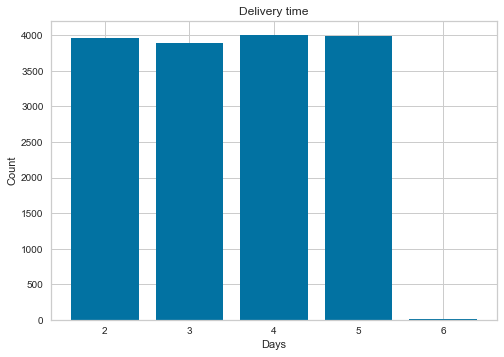

4    4003
5    3995
2    3963
3    3888
6      10
dtype: int64


In [666]:
delivery_days = (df_concat_chosen['delivery_timestamp'] - df_concat_chosen['purchase_timestamp']).dt.days
plt.bar(delivery_days.value_counts().keys(), delivery_days.value_counts())

plt.xlabel('Days')
plt.ylabel('Count')
plt.title("Delivery time")
plt.show()

print(delivery_days.value_counts())


In [667]:
median_delivery_days = np.median(delivery_days)
print(f'Median delivery days: {median_delivery_days}')


Median delivery days: 4.0


Powyzsza wartość zostanie wykorzystana w celu oszacowania ilości zwrotów przychodzącychh do magazynu dango dnia

In [668]:
df_concat_chosen.head()

,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29,2019-12-31
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30,2021-01-01
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13,2020-04-16


### Usunięcie zbędnych kolumn po kalkulacji

In [669]:
df_concat_chosen = df_concat_chosen.drop(['purchase_timestamp', 'delivery_timestamp'], axis=1)
df_concat_chosen.head()



,timestamp,event_type,category_path,price,brand,weight_kg,city
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin


In [670]:
event_type_history_count = df_concat_chosen[['timestamp', 'event_type']].groupby(
    ['timestamp', 'event_type']).agg({'event_type': 'count'})

event_type_history_count.columns = ['count']

event_type_history_count = event_type_history_count.reset_index()
event_type_history_count


,timestamp,event_type,count
0,2019-08-01,BUY_PRODUCT,15
1,2019-08-02,BUY_PRODUCT,19
2,2019-08-03,BUY_PRODUCT,14
3,2019-08-04,BUY_PRODUCT,17
4,2019-08-05,BUY_PRODUCT,15
...,...,...,...
1622,2022-04-11,BUY_PRODUCT,15
1623,2022-04-12,BUY_PRODUCT,7
1624,2022-04-13,RETURN_PRODUCT,1
1625,2022-04-16,RETURN_PRODUCT,1


# EDA

Wizualizacja ilości zwrotów z całego dostępnego okresu 

In [671]:
px.line(event_type_history_count, x='timestamp', y='count', color='event_type', title='Number of events')


W powyzszych danych występuje **sezonowość**, co moze pozytywnie wpłynąć na późniejsze tworzenie modelu.

### Czy ilość zamówień koreluje z ilością zwrotów?

Sprawdzenie, czy ilość zwracanych towarów koreluje z ilością zakupów na stronie

                           event_type_BUY_PRODUCT  event_type_RETURN_PRODUCT
event_type_BUY_PRODUCT                   1.000000                   0.030366
event_type_RETURN_PRODUCT                0.030366                   1.000000


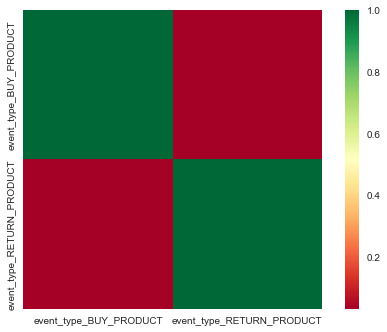

In [672]:
corr_matrix = pd.get_dummies(df_concat_chosen[['timestamp', 'event_type']], columns=['event_type']).groupby('timestamp').sum().corr()

sns.heatmap(corr_matrix, square=True, cmap='RdYlGn')
print(corr_matrix)


Korelacja jest praktycznie zerowa w związku z czym na początkowym etapie modelowania pominiemy ilość składanych zamówień

# Model 1 (Naive) - bazujący wyłącznie na historii zwrotów

## Feature engineering i preprocessing - utworzenie Pipeline

### Usuniecie sesji kupna `event_type`: `BUY_PRODUCT`

In [673]:
df_returns = df_concat_chosen[df_concat_chosen['event_type'] == 'RETURN_PRODUCT']
df_returns.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
11,2020-10-14,RETURN_PRODUCT,Tablety;Urządzenia,99.00,Lenovo,0.930,Szczecin
26,2021-11-27,RETURN_PRODUCT,Myszki;Bezprzewodowe,247.27,Razer,0.180,Radom
31,2021-12-07,RETURN_PRODUCT,Monitory komputerowe;Monitory,869.00,AOC,9.600,Radom
35,2020-10-18,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,158.00,Kingston,0.052,Radom


In [674]:
df_returns.shape

(1661, 7)

### Dodanie wcześniej wyznaczonego czasu zwrotu do danych

In [675]:
df_returns['timestamp'] = df_returns['timestamp'] + timedelta(days=median_delivery_days)
df_returns.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city
1,2020-02-12,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
11,2020-10-18,RETURN_PRODUCT,Tablety;Urządzenia,99.00,Lenovo,0.930,Szczecin
26,2021-12-01,RETURN_PRODUCT,Myszki;Bezprzewodowe,247.27,Razer,0.180,Radom
31,2021-12-11,RETURN_PRODUCT,Monitory komputerowe;Monitory,869.00,AOC,9.600,Radom
35,2020-10-22,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,158.00,Kingston,0.052,Radom


### Usunięcie zbędnych kolumn

In [676]:
df_model_1 = df_returns.drop(['price', 'brand', 'weight_kg', 'city', 'category_path'], axis=1)
df_model_1.head()


,timestamp,event_type
1,2020-02-12,RETURN_PRODUCT
11,2020-10-18,RETURN_PRODUCT
26,2021-12-01,RETURN_PRODUCT
31,2021-12-11,RETURN_PRODUCT
35,2020-10-22,RETURN_PRODUCT


### Dodanie etykiet (labeli) - zliczenie dziennej ilości zwrotów

In [677]:
df_model_1 = df_model_1.groupby('timestamp').count()
df_model_1.rename(columns={'event_type': 'num_returns'}, inplace=True)
df_model_1.head()

,num_returns
timestamp,
2019-08-16,2
2019-08-19,1
2019-08-20,1
2019-08-25,2
2019-08-28,1


### Posortowanie danych po dacie

In [678]:
df_model_1.sort_index(inplace=True)

### Zapewnienie stałej częstotliwości

Zgodnie z załozeniami, model ma przewidywać dzienną ilość zwrotów, na 2 tygodnie w przód. Nalezy zatem zbiór danych zmodyfikować w ten sposób, aby widniały w nim dane pochodzące z kazdego dnia od początku, do końca przedziału. W dni nieuwzględnione w dotychczasowych danych wpiszemy 0, gdyz nie dochodziło wtedy do zadnych zwrotów. Zakładamy, ze magazyn pracuje 7 dni w tygodniu, stąd tez nie musimy wyróniać dni pracujących.

In [679]:
print('Zakres modelowanych danych:')
df_model_1.index.min(), df_model_1.index.max()


Zakres modelowanych danych:


(datetime.date(2019, 8, 16), datetime.date(2022, 4, 28))

Dostępne dane pochodzą z okresu prawie 3 lat, co powinno umozliwić bezproblemowe podzielenie zbioru danych na treningowy oraz walidacyjny.

In [680]:
df_model_1_daily = df_model_1.copy()
df_model_1_daily = df_model_1.asfreq('d', fill_value=0)

print(f'Ilość danych przed transformacją {df_model_1.shape[0]}')
print(f'Ilość danych po transformacji {df_model_1_daily.shape[0]}')


Ilość danych przed transformacją 641
Ilość danych po transformacji 987


In [681]:
df_model_1_prep = df_model_1_daily.copy()
df_model_1_prep = df_model_1_prep.reset_index()
df_model_1_prep.head()


,timestamp,num_returns
0,2019-08-16,2
1,2019-08-17,0
2,2019-08-18,0
3,2019-08-19,1
4,2019-08-20,1


In [682]:
df_model_1_prep['day'] = df_model_1_prep['timestamp'].dt.day
df_model_1_prep['month'] = df_model_1_prep['timestamp'].dt.month
df_model_1_prep['year'] = df_model_1_prep['timestamp'].dt.year
df_model_1_prep.drop('timestamp', axis=1, inplace=True)


In [683]:
df_model_1_prep.head()

,num_returns,day,month,year
0,2,16,8,2019
1,0,17,8,2019
2,0,18,8,2019
3,1,19,8,2019
4,1,20,8,2019


## Rozdzielenie danych

Rozdzielenie danych na atrybuty i etykiety

- Atrybuty

In [684]:
X = df_model_1_prep.drop(['num_returns'], axis=1).to_numpy()
X.shape

(987, 3)

- Etykiety

In [685]:
y = df_model_1_prep['num_returns'].to_numpy()
y.shape

(987,)

## Podział na zbiory

Podział na zbiór treningowy oraz testowy

Podczas definiowania analitycznych kryterów sukcesu, wyznaczona dokładność wynosiła do 5 zwrotów na 2 tygodnie. Podzielimy zatem dane, na zbiór treningowy (~85%) oraz walidacyjny (140 dni ~ 14%)

In [686]:
boundary_idx = len(df_model_1_prep) - (int((len(df_model_1_prep) / 14) - (0.85 * (len(df_model_1_prep) / 14))) * 14)
boundary_idx


847

- Train

In [687]:
X_train, y_train = X[:boundary_idx], y[:boundary_idx]
X_train.shape, y_train.shape


((847, 3), (847,))

In [688]:
X_train

array([[  16,    8, 2019],
       [  17,    8, 2019],
       [  18,    8, 2019],
       ...,
       [   7,   12, 2021],
       [   8,   12, 2021],
       [   9,   12, 2021]])

- Validation

In [689]:
X_valid, y_valid = X[boundary_idx:], y[boundary_idx:]
X_valid.shape, y_valid.shape


((140, 3), (140,))

## Dodanie cykliczności

Dostarczone dane są cykliczne (dni, miesiące są powtarzalne). Niemniej jednak, owa cykliczność nie zostanie "zrozumiana" przez tworzone modele.

W celu cyklicznej reprezentacji danych, która będzie "rozumiana" przez tworzone modele posłuzymy się metodą przedstawioną w [ponizszym artykule](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/).

In [690]:
class CycleTransformer:
    """Creates 2 new columns to represent cyclic data.
    Applies sine and cosine function to the original column 
    """

    def __init__(self, column_idxs, num_unique_list):
        """Initializes the CycleTransformer object.

        Args:
            column_idxs (list): list of column indicies which to transform
            num_unique (list[int]): list containing the number of unique values that each feature can have
        """
        self.num_unique_list = num_unique_list
        self.column_idxs = column_idxs

    def fit(self):
        return self

    def fit_transform(self, X, y=None):
        """Calls the `transform` method

        Args:
            X (np.ndarray): 2D numpy array containing the data in rows and columns.
            y (list, optional): list or numpy array containing the corresponding labels. Defaults to None.

        Returns:
            _type_: _description_
        """
        return self.transform(X, y)

    def transform(self, X, y=None):
        """Creates 2 new columns, drops the original column

        Args:
            X (np.ndarray): 2D numpy array containing the data in rows and columns.
            y (list, optional): list or numpy array containing the corresponding labels. Defaults to None.
        """

        X_new = X.copy()
        X_new = np.delete(X_new, self.column_idxs, axis=1)

        for column_idx, num_unique in zip(self.column_idxs, self.num_unique_list):
            new_sin_feature = np.sin(2 * np.pi * X[:, column_idx] / num_unique).reshape(-1, 1)
            new_cos_feature = np.cos(2 * np.pi * X[:, column_idx] / num_unique).reshape(-1, 1)
            X_new = np.append(X_new, new_sin_feature, axis=1)
            X_new = np.append(X_new, new_cos_feature, axis=1)
        return X_new

## Skalowanie

In [691]:
from sklearn.preprocessing import MinMaxScaler

## Pipeline

In [692]:
from sklearn.pipeline import Pipeline

In [693]:
feature_pipeline = Pipeline(steps=[
    ('cyclic_transform', CycleTransformer(column_idxs=[0, 1], num_unique_list=[MAX_MONTH_DAYS, NUM_MONTHS])),
    ('scaling', MinMaxScaler())
    ])

In [694]:
X_train_prep = feature_pipeline.fit_transform(X_train, y_train)


In [695]:
X_valid_prep = feature_pipeline.transform(X_valid)


In [696]:
X_train_prep.shape, X_valid_prep.shape


((847, 5), (140, 5))

### Automatyczne tworzenie pipeline

In [697]:
def create_pipeline(transformers: List[Tuple[str, object]], model, target_transformer=None, transform_func=None, inverse_transform_func=None):
    """_summary_

    Args:
        transformers (List[Tuple[str, object]]): _description_
        model (_type_): _description_
        target_transformer (_type_, optional): _description_. Defaults to None.
        transform_func (_type_, optional): _description_. Defaults to None.
        inverse_transform_func (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """

    pipeline_steps = [(transformer) for transformer in transformers]
    pipeline_steps.append(('model', model))
    pipeline = Pipeline(steps=pipeline_steps)

    if target_transformer is not None:
        return target_transformer(pipeline, func=transform_func, inverse_func=inverse_transform_func)
    return pipeline


## Początek modelowania

## PyCaret

W celu wyboru optymalnego modelu do rozpoczęcia procesu modelowania wykorzystamy bibliotekę PyCaret, która pozwala na szybkie zestawienie wyników wielu modeli. Uzyjemy tutaj wcześniej przetworzonych danych (bez wykorzystania pipeline) 

In [698]:
from pycaret.regression import *

Niestety moduł PyCaret do regersji nie przyjmuje etykiet o wartości równej `0`. Podmienimy zatem tę wartość na równie małą np. `0.01` 

In [699]:
data_columns = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'year']

y_train_pycaret = np.where(y_train == 0, 0.01, y_train)
y_valid_pycaret = np.where(y_valid == 0, 0.01, y_valid)

pycaret_train_df = pd.concat([pd.DataFrame(X_train_prep, columns=data_columns), pd.Series(y_train_pycaret, name='num_returns')], axis=1)
pycaret_valid_df = pd.concat([pd.DataFrame(X_valid_prep, columns=data_columns), pd.Series(y_valid_pycaret, name='num_returns')], axis=1)

pycaret_train_df.head()


,day_sin,day_cos,month_sin,month_cos,year,num_returns
0,0.0,0.449351,0.000000,0.066987,0.25,2.00
1,0.0,0.350126,0.020417,0.066987,0.25,0.01
2,0.0,0.257037,0.060416,0.066987,0.25,0.01
3,0.0,0.173895,0.118359,0.066987,0.25,1.00
4,0.0,0.104104,0.191874,0.066987,0.25,1.00


In [700]:
s = setup(data=pycaret_train_df, test_data=pycaret_valid_df, target='num_returns', fold_strategy='timeseries',
          numeric_features=data_columns, fold=3, transform_target=True, session_id=123)


,Description,Value
0,session_id,123
1,Target,num_returns
2,Original Data,"(847, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(847, 5)"


In [701]:
best = compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.0152,2.4543,1.5087,0.2759,0.5709,21.5820,0.0400
lightgbm,Light Gradient Boosting Machine,1.0860,3.0625,1.6786,0.1380,0.5877,21.4659,0.2500
et,Extra Trees Regressor,1.1101,2.8148,1.6081,0.1947,0.6224,30.3366,0.0300
gbr,Gradient Boosting Regressor,1.1289,2.9916,1.6799,0.0471,0.6021,22.3361,0.0133
ada,AdaBoost Regressor,1.1381,3.7407,1.7973,0.0818,0.5950,18.0002,0.2533
huber,Huber Regressor,1.2033,4.6761,2.0557,-0.1897,0.6458,17.2134,0.6467
omp,Orthogonal Matching Pursuit,1.2126,5.1757,2.1392,-0.2424,0.6511,15.5606,0.0033
ridge,Ridge Regression,1.2153,5.0468,2.1215,-0.2269,0.6531,14.5179,0.2567
lar,Least Angle Regression,1.2166,5.0293,2.1221,-0.2391,0.6580,14.4766,0.0033
lr,Linear Regression,1.2166,5.0293,2.1221,-0.2391,0.6580,14.4766,0.7267


Na naszych danych najlepiej spisuje się model losowego lasu. Będzie to dobry punkt startowy do wyłonienia najlepszego modelu.

In [702]:
predict_model(best, data=pycaret_valid_df).head(70)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1.2421,3.6509,1.9107,0.6289,0.5441,13.4632


,day_sin,day_cos,month_sin,month_cos,year,num_returns,Label
0,1.0,0.949479,2.779506e-01,0.500000,1.00,5.00,5.815114
1,1.0,0.895896,1.918739e-01,0.500000,1.00,2.00,4.108707
2,1.0,0.826105,1.183592e-01,0.500000,1.00,2.00,1.988252
3,1.0,0.742963,6.041634e-02,0.500000,1.00,1.00,3.487305
4,1.0,0.649874,2.041741e-02,0.500000,1.00,2.00,3.194365
...,...,...,...,...,...,...,...
65,1.5,0.742963,6.041634e-02,0.933013,0.75,2.00,0.802024
66,1.5,0.649874,2.041741e-02,0.933013,0.75,0.01,1.268013
67,1.5,0.550649,5.551115e-17,0.933013,0.75,0.01,0.057367
68,1.5,0.449351,0.000000e+00,0.933013,0.75,5.00,0.264810


In [703]:
evaluate_model(best)

,Parameters
bootstrap,True
ccp_alpha,0.0
criterion,mse
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None
min_samples_leaf,1


## Ewaluacja modeli - walidacja krzyzowa (Cross Validation)

W celu pierwszej oceny jakości modeli wykorzystamy walidację krzyzową.

![](https://miro.medium.com/max/1204/1*qvdnPF8ETV9mFdMT0Y_BBA.png)

In [704]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [705]:
def ts_cross_val_score(model, X, y, cv=5, eval_func=None):
    """Performs cross validation for time series data

    Args:
        model (_type_): _description_
        X (Union[np.ndarray, ]): _description_
        y (_type_): _description_
        cv (int, optional): number of folds. Defaults to 5.
        eval_func (Callable[y_true, y_pred], optional): _description_. Defaults to None.

    Returns:
        list: list of scores for each foold
    """
    ts_split_cv = TimeSeriesSplit(n_splits=cv)

    scores = []

    for train_idx, val_idx in ts_split_cv.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        score = eval_func(y_val_cv, y_pred)
        scores.append(score)
    return scores


## Linear Regression - najprostszy, bazowy model

Regresja liniowa, to najprostszy model rozwiązujący zadanie regresji. Nie pozwoli on prawdopodobnie uzyskać zadowalających wyników, natomiast jest dobrym punktem startowym.

In [706]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

In [707]:
cycle_transformer = CycleTransformer(column_idxs=[0, 1], num_unique_list=[MAX_MONTH_DAYS, NUM_MONTHS])
scaler = MinMaxScaler()
lr_model = LinearRegression()

data_transformers = [('cyclic_transform', cycle_transformer),
                     ('scaling', scaler)]

lr_model_pipeline = create_pipeline(transformers=data_transformers,
                                    model=lr_model,
                                    target_transformer=TransformedTargetRegressor,
                                    inverse_transform_func=np.round
                                    )


In [708]:
scores = ts_cross_val_score(lr_model_pipeline, X_train, y_train, cv=5, eval_func=mean_absolute_error)

print('MAE scores:', scores)
print('MAE scores:', np.mean(scores))


MAE scores: [8.97872340425532, 2.2411347517730498, 2.24822695035461, 1.0567375886524824, 1.297872340425532]
MAE scores: 3.1645390070921984


### Trenowanie prostego modelu

In [709]:
lr_model_pipeline.fit(X_train, y_train)


TransformedTargetRegressor(check_inverse=True, func=None,
                           inverse_func=<function round_ at 0x107c61d30>,
                           regressor=Pipeline(memory=None,
                                              steps=[('cyclic_transform',
                                                      <__main__.CycleTransformer object at 0x16b9a5eb0>),
                                                     ('scaling',
                                                      MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1))),
                                                     ('model',
                                                      LinearRegression(copy_X=True,
                                                                       fit_intercept=True,
                                                                       n_jo

In [710]:
y_pred = lr_model_pipeline.predict(X_valid)


In [711]:
mean_absolute_error(y_valid, y_pred)


1.9714285714285715

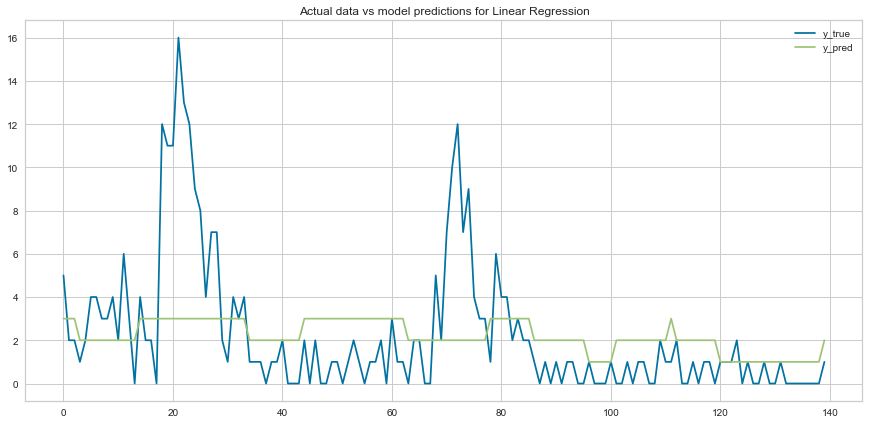

In [712]:
plot_predictions(y_valid, y_pred, model_name='Linear Regression')

Zgodnie z przewidywaniami, model radzi sobie raczej słabo. Spróbujemy z bardziej złozonym modelem

### Zapisanie wytrenowanego modelu

In [713]:
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

filename = 'linear_regression_model.joblib'
model_path = os.path.join(MODELS_DIR, filename)

save_model_pipeline(lr_model_pipeline, model_path)

## Polynomial Regression - średniozaawansowany model

Po wytrenowaniu najbardziej podstawowego modelu - regresji liniowej, rozszerzymy go o cechy wielomianowe.

In [714]:
from sklearn.preprocessing import PolynomialFeatures

In [715]:
cycle_transformer = CycleTransformer(column_idxs=[0, 1], num_unique_list=[
                                     MAX_MONTH_DAYS, NUM_MONTHS])
scaler = MinMaxScaler()

poly_reg_model = Pipeline(steps=[('poly_features', PolynomialFeatures(degree=2)),
                                 ('lin_reg', LinearRegression())])

data_transformers = [('cyclic_transform', cycle_transformer),
                     ('scaling', scaler)]

poly_reg_model_pipeline = create_pipeline(transformers=data_transformers,
                                    model=poly_reg_model,
                                    target_transformer=TransformedTargetRegressor,
                                    inverse_transform_func=np.round
                                    )


### Cross validation

In [716]:
scores = ts_cross_val_score(poly_reg_model_pipeline, X_train, y_train, cv=5, eval_func=mean_absolute_error)

print('MAE scores:', scores)
print('MAE scores:', np.mean(scores))


MAE scores: [88774345609.03546, 11.326241134751774, 129407142391994.22, 0.950354609929078, 1.75177304964539]
MAE scores: 25899183347523.457


In [717]:
poly_reg_model_pipeline.fit(X_train, y_train)

TransformedTargetRegressor(check_inverse=True, func=None,
                           inverse_func=<function round_ at 0x107c61d30>,
                           regressor=Pipeline(memory=None,
                                              steps=[('cyclic_transform',
                                                      <__main__.CycleTransformer object at 0x16bb33c10>),
                                                     ('scaling',
                                                      MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1))),
                                                     ('model',
                                                      Pipeline(memory=None,
                                                               steps=[('poly_features',
                                                                       PolynomialFeatu

In [718]:
y_pred = poly_reg_model_pipeline.predict(X_valid)

In [719]:
mean_absolute_error(y_valid, y_pred)

1.7857142857142858

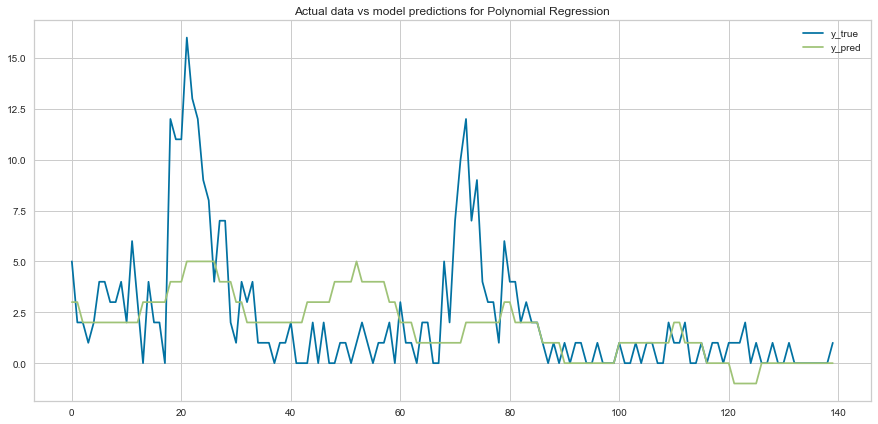

In [720]:
plot_predictions(y_valid, y_pred, model_name='Polynomial Regression')

Widzimy tutaj pewną poprawę. Nie jest ona jednak duza w porównaniu do poprzedniego modelu regresji liniowej.

## Random Forest

Po sprawdzeniu prostych modeli przyszedł czas na bardziej złozony. Z poprzedniej ewaluacji przeprowadzonej z wykorzystaniem modułu `PyCaret` wiemy, ze w rozwiązaniu naszego problemu bardzo dobrze poradził sobie model losowego lasu. W związku z tym skupimy się właśnie na tym modelu.

In [721]:
from sklearn.ensemble import RandomForestRegressor


In [722]:
cycle_transformer = CycleTransformer(column_idxs=[0, 1], num_unique_list=[
                                     MAX_MONTH_DAYS, NUM_MONTHS])
scaler = MinMaxScaler()

rf_model = RandomForestRegressor(n_estimators=200, min_samples_leaf=0.001, random_state=42)

data_transformers = [('cyclic_transform', cycle_transformer),
                     ('scaling', scaler)]

rf_model_pipeline = create_pipeline(transformers=data_transformers,
                                    model=rf_model,
                                    target_transformer=TransformedTargetRegressor,
                                    inverse_transform_func=np.round
                                    )


### Cross validation

In [723]:
scores = ts_cross_val_score(rf_model_pipeline, X_train, y_train, cv=5, eval_func=mean_absolute_error)

print('MAE scores:', scores)
print('MAE scores:', np.mean(scores))


MAE scores: [4.76595744680851, 0.8226950354609929, 1.6879432624113475, 1.3829787234042554, 0.9645390070921985]
MAE scores: 1.924822695035461


Juz na tym etapie widać, ze model losowego lasu znacznie lepiej radzi sobie z rozwiązaniem naszego problemu w porównaniu do poprzednich modelu.

Wytrenujmy model i sprawdźmy wyniki.

In [724]:
rf_model_pipeline.fit(X_train, y_train)


TransformedTargetRegressor(check_inverse=True, func=None,
                           inverse_func=<function round_ at 0x107c61d30>,
                           regressor=Pipeline(memory=None,
                                              steps=[('cyclic_transform',
                                                      <__main__.CycleTransformer object at 0x16b7ba8b0>),
                                                     ('scaling',
                                                      MinMaxScaler(copy=True,
                                                                   feature_range=(0,
                                                                                  1))),
                                                     ('model',
                                                      RandomForestRegressor(bootstrap=True,
                                                                            ccp_alpha=0.0,
                                                                   

In [725]:
y_pred = rf_model_pipeline.predict(X_valid)

In [726]:
mean_absolute_error(y_valid, y_pred)

1.2

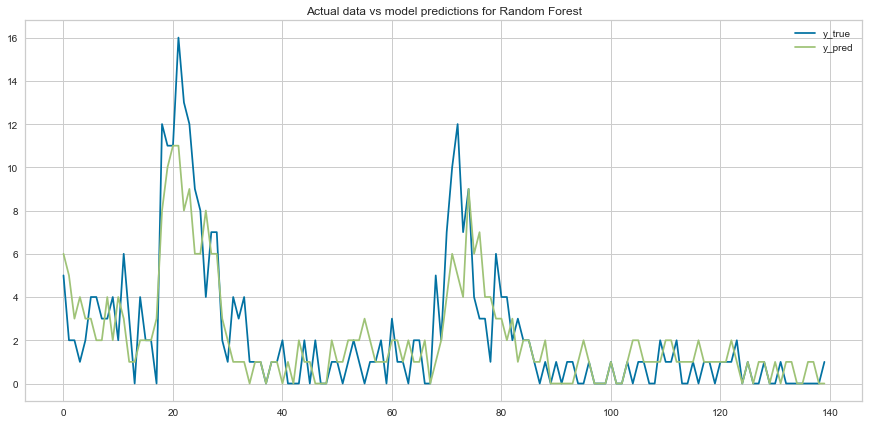

In [727]:
plot_predictions(y_valid, y_pred, model_name='Random Forest')

Model zgodnie z oczekiwaniem wydaje się działać dobrze, a na pewno lepiej od prostych modeli liniowych. Aby zwiększyć jego dokładność przeprowadzimy strojenie hiperparametrów (HPO)

## Strojenie hiperparametrów - HPO

In [728]:
from sklearn.model_selection import RandomizedSearchCV

In [729]:
rf_params = {"regressor__model__n_estimators": [None, *np.linspace(1, 600, 20, dtype=int)],
             "regressor__model__max_depth": [None, *np.linspace(1, 300, 50, dtype=int)],
             "regressor__model__min_samples_split": np.concatenate((np.linspace(0.001, 1, 200), np.linspace(1, 50, 100, dtype=int))),
             "regressor__model__min_samples_leaf": np.concatenate((np.linspace(0.001, 0.5, 100), np.linspace(1, 200, 100, dtype=int))),
             "regressor__model__min_weight_fraction_leaf": (np.linspace(0, 0.5, 30)),
             "regressor__model__max_leaf_nodes": [None, *np.linspace(1, 200, 20, dtype=int)],
             "regressor__model__min_impurity_decrease": (np.linspace(0, 1, 30)),
             }


In [730]:
ts_split_cv = TimeSeriesSplit(n_splits=5)

param_search = RandomizedSearchCV(rf_model_pipeline, rf_params, cv=ts_split_cv)


In [731]:
param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=TransformedTargetRegressor(check_inverse=True,
                                                        func=None,
                                                        inverse_func=<function round_ at 0x107c61d30>,
                                                        regressor=Pipeline(memory=None,
                                                                           steps=[('cyclic_transform',
                                                                                   <__main__.CycleTransformer object at 0x16b7ba8b0>),
                                                                                  ('scaling',
                                                                                   MinMaxScaler(copy=True,
                                                                                                feature_range=(...
    

In [732]:
param_search.best_score_

-0.11657923560828883

In [733]:
param_search.best_params_


{'regressor__model__n_estimators': 379,
 'regressor__model__min_weight_fraction_leaf': 0.41379310344827586,
 'regressor__model__min_samples_split': 0.3724874371859297,
 'regressor__model__min_samples_leaf': 0.11188888888888888,
 'regressor__model__min_impurity_decrease': 0.8620689655172413,
 'regressor__model__max_leaf_nodes': 116,
 'regressor__model__max_depth': 245}

In [734]:
rf_best_model = param_search.best_estimator_


In [735]:
y_pred = rf_best_model.predict(X_valid)


In [736]:
mean_absolute_error(y_valid, y_pred)

1.7571428571428571

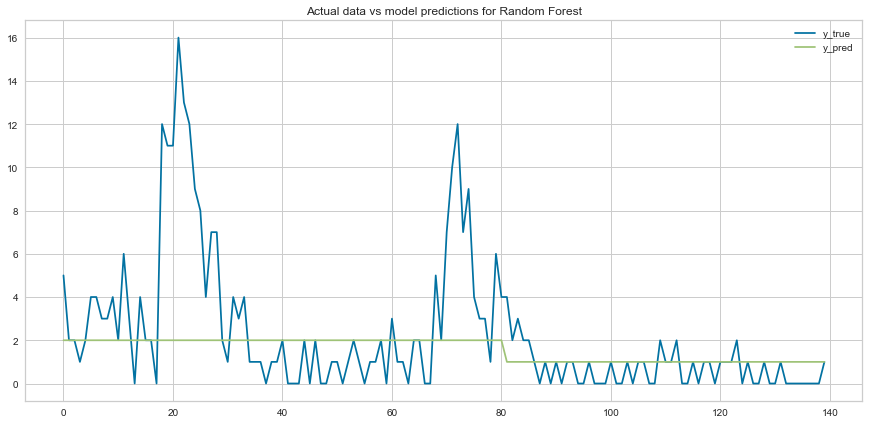

In [737]:
plot_predictions(y_valid, y_pred, model_name='Random Forest')

Po wielu próbach strojenia hiperparametów model się przeucza. Postanowiliśmy pozostać przy jego pierwonie wytrenowanej wersji, gdyz wyniki są znacznie bardziej satysfakcjonujące.

## Zapisanie pierwotnie wytrenowanego modelu

In [738]:
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

filename = 'random_forest_model.joblib'
model_path = os.path.join(MODELS_DIR, filename)

save_model_pipeline(rf_model_pipeline, model_path)


## Ładowanie wytrenowanego modelu

In [739]:
import joblib
import numpy as np
from sklearn.compose import TransformedTargetRegressor

In [740]:
MODELS_DIR = 'models'

In [741]:
class CycleTransformer:
    """Creates 2 new columns to represent cyclic data.
    Applies sine and cosine function to the original column 
    """

    def __init__(self, column_idxs, num_unique_list):
        """Initializes the CycleTransformer object.

        Args:
            column_idxs (list): list of column indicies which to transform
            num_unique (list[int]): list containing the number of unique values that each feature can have
        """
        self.num_unique_list = num_unique_list
        self.column_idxs = column_idxs

    def fit(self):
        return self

    def fit_transform(self, X, y=None):
        """Calls the `transform` method

        Args:
            X (np.ndarray): 2D numpy array containing the data in rows and columns.
            y (list, optional): list or numpy array containing the corresponding labels. Defaults to None.

        Returns:
            _type_: _description_
        """
        return self.transform(X, y)

    def transform(self, X, y=None):
        """Creates 2 new columns, drops the original column

        Args:
            X (np.ndarray): 2D numpy array containing the data in rows and columns.
            y (list, optional): list or numpy array containing the corresponding labels. Defaults to None.
        """

        X_new = X.copy()
        X_new = np.delete(X_new, self.column_idxs, axis=1)

        for column_idx, num_unique in zip(self.column_idxs, self.num_unique_list):
            new_sin_feature = np.sin(2 * np.pi * X[:, column_idx] / num_unique).reshape(-1, 1)
            new_cos_feature = np.cos(2 * np.pi * X[:, column_idx] / num_unique).reshape(-1, 1)
            X_new = np.append(X_new, new_sin_feature, axis=1)
            X_new = np.append(X_new, new_cos_feature, axis=1)
        return X_new

In [742]:
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

filename = 'random_forest_model.joblib'
model_path = os.path.join(MODELS_DIR, filename)

In [743]:
loaded_rf_model = load_model_pipeline(model_path)


In [744]:
y_pred = loaded_rf_model.predict(np.array([[10, 2, 2020]]))
y_pred


array([1.])

## Ewaluacja zgodnie z kryterium analitycznym (ile błędów dla okresów 2 tygodni)

In [745]:
def evaluate_model(y_true, y_pred, score_function, days=1):
    """Evaluates a time series model.

    Args:
        score_function (_type_): _description_
        days (int, optional): _description_. Defaults to 14.
    """
    return score_function(y_true, y_pred) * days

In [746]:
y_pred = loaded_rf_model.predict(X_valid)

evaluate_model(y_valid, y_pred, mean_absolute_error, days=14)

16.8

## Wnioski

Prawie udało się osiągnąć zakładane kryterium analityczne, czyli dokładność do 15 zwrotów na 2 tygodnie. Parametry modelu mozna dalej próbować stroić w celu osiągnięcia zakładanego kryterium.

## Potencjał rozwojowy

- wytrenowanie modelu XGBoost
- utworzenie nowego atrybutu, przechowującego liczbę zakupionych towarów w ostatnich 2 tygodniach
- dodanie atrybutu ze średnią cena zakupionych towarów w ostatnich dwóch tygodniach
- dodanie dnia tygodnia do danych
- wykorzystanie sekwencji zakupionych produktów na wejściu (sieć rekurencyjna, LSTM)